# RA Diagnosis Extraction with Machine Learning
This notebook is built for extracting the diagnosis from format-free textfields of Electronic Medical Health records. 
- Feel free to make some adjustments that better correspond with your data

In [47]:
SEED = 26062019

test_size = 0.5 

import sys
sys.path.append('/exports/reum/tdmaarseveen/modules')
import scipy
from yellowbrick import __version__ as yb_vers
from sklearn import __version__ as sk_vers
import buildingAClassifier as bc
from pattern import __version__ as pat_vers
import matplotlib.pyplot as plt
import random
import numpy as np
import pandas as pd
from sklearn import datasets, svm, model_selection, tree, preprocessing, metrics
import sklearn.ensemble as ske
from matplotlib import __version__ as m_vers
import re
import random
import pickle
import xgboost as xgb

print('Current versions Modules:\n')
print('Pandas version:\t\t' + pd.__version__)
print('Matplotlib version:\t' + m_vers)
print('numpy version:\t\t' + np.__version__)
print('sklearn version:\t' + sk_vers)
print('scipy version:\t\t' + scipy.__version__)
print('pattern version:\t' + pat_vers)
print('yellowbrick version:\t' + yb_vers)
print('xgb version:\t\t' + xgb.__version__)

Current versions Modules:

Pandas version:		0.23.0
Matplotlib version:	2.2.2
numpy version:		1.17.0
sklearn version:	0.21.2
scipy version:		1.1.0
pattern version:	3.6
yellowbrick version:	0.9.1
xgb version:		0.90


## Step 1: Cleaning Data with NLP methods
Applying Natural Language Processing algorithms:
- Word segmentation: words are split on whitespace -> special characters are removed
- lemmatization: words are returned to the root form (if word is in corpus) - default= Dutch (nl)
- Typocorrection
- XML artefact removal

The aforementioned functions can be useful, depending on the quality of the data

### 1.1 Open raw file
In our data we have the following columns: 
- XANTWOORD= free text field from the EMR (Conclusion)
- Outcome= associated label:
    - 'y' = RA-case
    - 'n' = not an RA-case

In [9]:
radiag_df = pd.read_csv(r'data/annotation_v2_20190125.csv', sep='|')
radiag_df['Outcome'] = radiag_df['Outcome'].apply(lambda x: 'y' if x == 'j' else 'n')
radiag_df[['XANTWOORD', 'Outcome']].head()

,XANTWOORD,Outcome
0,psoa in remissie,n
1,1 . slotklachten beide knieen dd meniscusprobl...,n
2,polyartritis,n
3,"1 . artritis psoriatica , twee gewrichten onst...",n
4,rustige jia ^meerdere ok ' s te radbout zh,n


### 1.2 Create Dutch dictionary for EMR
1. Source for dictionary files (multiple languages) - https://github.com/titoBouzout/Dictionaries 
2. If left unchanged this step only applies if you're working with Dutch data

In [ ]:
def readDictionary(location):
    return list(pd.read_csv(location, sep='/').index)

l_custom= list(pd.read_csv('corpus/Custom.dic', sep=';')) # custom dutch clinical vocab
l_dutch= readDictionary('corpus/Dutch.dic') # dutch dictionary

l_dutch.extend(l_custom) # combine dutch dictionary with the custom dict
l_new = [bc.removeAccent(bc.processArtefactsXML(i)) for i in l_dutch]
print('Dic:\t\t\t', str(len(l_new)))
l_new = [i for i in l_new if i.lower() == i]
l_new = [i for i in l_new if len(i) > 2]
print('Dic (names removed):\t', str(len(l_new)))

### 1.3 Preprocessing - Word segmentation and lemmatizing 
The typo correction step is currently muted on purpose, because this step only applies if you're working with Dutch data

In [14]:
import importlib as imp
imp.reload(bc)
import time

radiag_df['XANTWOORD'] = radiag_df['XANTWOORD'].apply(lambda x : bc.processArtefactsXML(str(x)))
radiag_df['XANTWOORD'] = radiag_df['XANTWOORD'].apply(lambda x : bc.simpleCleaning(x, lemma=False))

# Apply TypoCorrection  
  #  typocor = bc.TypoCorrection(np.array(l_new)) # provide word list
  #  t0 = time.time()
  #  radiag_df['XANTWOORD'] = radiag_df['XANTWOORD'].apply(lambda x : typocor.correct(x))
  #  t1 = time.time()
  #  print('Time for TypoCorrection (n=' + str(len(radiag_df)) + ') : ' + str(t1-t0))

radiag_df['XANTWOORD'] = radiag_df['XANTWOORD'].apply(lambda x : bc.lemmatizingText(x, lan='nl')) # 'en' for english & 'de' for german
radiag_df=radiag_df.fillna('')

# Save autocorrected dataframe
radiag_df.to_csv(r'data/autocorrect_something.csv', sep='|', index=False)

## Step 2: Structuring the data

### 2.1 Open the preprocessed file
You can skip the above steps if you already have a preprocessed file

In [6]:
radiag_df = pd.read_csv(r'data/autocorrect_something.csv', sep='|')
radiag_df[['XANTWOORD', 'Outcome']].head()

,XANTWOORD,Outcome
0,verhoog leverenzym waarschijnlijk tgv mtx lda ...,n
1,oligoartritis zien acpa rf en familie anamnee ...,y
2,rvk polyarticulair topheus erosief jicht dysur...,n
3,ankyloseer spondylitis o b v bilateraal sacroi...,n
4,jarig pen oa bekend met colitis ulcerosa wv st...,y


### 2.2 Balancing classes in data (Proportion RA cases vs. non cases) - Optional
The number of non-cases is larger than nr. of cases so a random sample of non cases is selected to create a balance between the classes. 
- Optional: Whether or not you want to balance the classes depends on the expected prevalence of the cases in the test data. 
- You could also choose to balance the classes in a different way (eg: 1:5) but it should always correspond with the expected prevalence in the test set. Choose the desired nr of samples by changing nr_of_samples

Be careful: by default the data is not balanced

In [15]:
balance = False
nr_of_samples = len(radiag_df[radiag_df['Outcome']=='y'])

if (balance):
    df_no_outcome = radiag_df[radiag_df['Outcome']=='n'].sample(n=nr_of_samples, random_state=SEED)
    equal_radiag_df = pd.concat([df_no_outcome, radiag_df[radiag_df['Outcome']=='y']])
    radiag_df = equal_radiag_df.sample(frac=1, random_state=SEED)

### 2.3 Splitting annotated set on both the textual data and the corresponding label (Y)

In [16]:
X = radiag_df['XANTWOORD'].values
y = radiag_df['Outcome'].values
y_b = np.array([bc.binarize(val) for val in y])

### 2.4 Visualizing the data
#### Plot: Prevalence of RA-cases
Positive control -> classes should be in balance

(1784, 2, 154, 57, 2, 1)


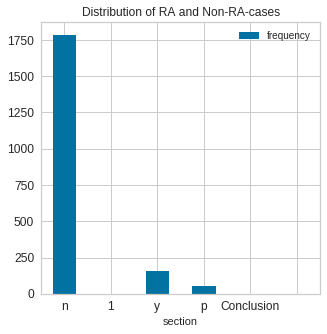

In [17]:
from collections import Counter

labels, values = zip(*Counter(y).items())
print(values)
df = pd.DataFrame({'section':labels, 'frequency':values})
ax = df.plot(kind='bar',  title ="Distribution of RA and Non-RA-cases", figsize=(5, 5), x='section', legend=True, fontsize=12, rot=0)

#### Plot: Lexical Dispersion Plot
- Showcases the prevalence of features
- The feature’s homogeneity across the entries

/home/tdmaarseveen/.conda/envs/ml_env/lib/python3.5/site-packages/ipykernel_launcher.py:4: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  after removing the cwd from sys.path.


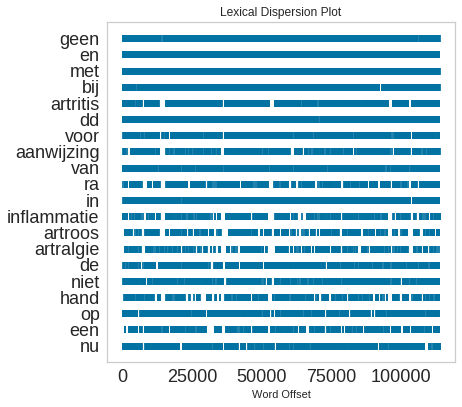

In [18]:
import importlib
importlib.reload(bc)

bc.plotLexicalDispersion(X, nr_features=20, ngram_range=(1,1))

#### Plot: Feature distribution

<module 'matplotlib.pyplot' from '/home/tdmaarseveen/.conda/envs/ml_env/lib/python3.5/site-packages/matplotlib/pyplot.py'>

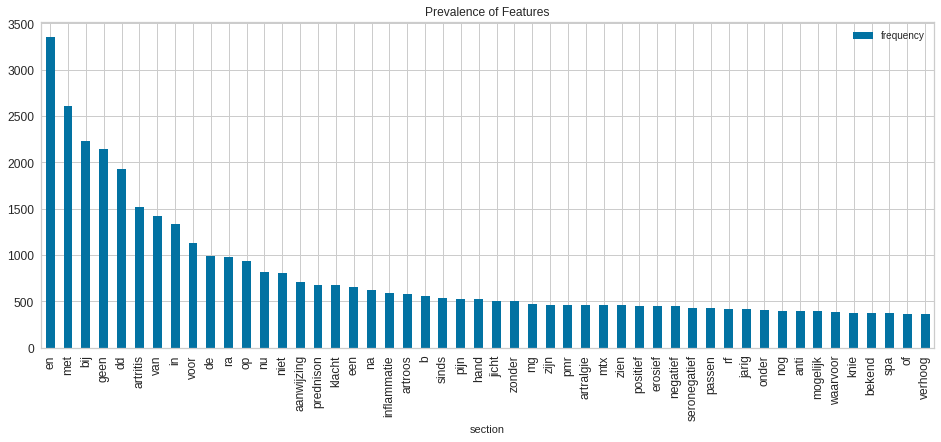

In [19]:
bc.plotSampleDistribution(X, nr_features=50) 

## Step 3: Building the Pipeline & Fitting models
import all of the classifiers that you want to apply/compare

### 3.1 Import different classification models:
Listed below are the following models: Naive Bayes, Gradient Boosting, Neural Networks, Decision tree & SVM.

In [20]:
from sklearn.naive_bayes import MultinomialNB
from sklearn.pipeline import Pipeline
from sklearn.linear_model import SGDClassifier
from sklearn.svm import SVC
from sklearn.neural_network import MLPClassifier
from sklearn.neural_network import MLPRegressor
from sklearn import tree
from sklearn.metrics import accuracy_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.dummy import DummyClassifier
# from xgboost import XGBClassifier

### 3.2 Initialize the different models

#### Word Matching
The word matching method classifies based on the presence of the provided targets.

The following targets are provided: 'rheumatoid arthritis', 'reumatoide artritis' and 'ra' (Dutch)

In [21]:
import TextClassification as tc
l_targets = ['rheumatoid arthritis', 'reumatoide artritis', 'ra']

WordMatching = tc.CustomBinaryModel(l_targets)

#### Initialize classifiers
All methods except for the naive word matching method require vectorized data. Hence, the classifiers are accompanied with a TfidfVectorizer function 

In [50]:
SEED=26062019
models = [
    WordMatching,
    # Naive Bayes - 0
    Pipeline([('vect', TfidfVectorizer(ngram_range=(1, 3))),
                ('clf', MultinomialNB()),
            ]),
    # Gradient Boosting - 1
    Pipeline([('vect', TfidfVectorizer(ngram_range=(1, 3))),
                ('clf', ske.GradientBoostingClassifier(random_state=SEED))
            ]),
    # Neural Networks - 2
    Pipeline([('vect', TfidfVectorizer(ngram_range=(1, 3))),
                ('clf', MLPClassifier(solver='lbfgs', random_state=SEED)), # hidden_layer_sizes=(5, 2), , 
            ]),
    # Decision Tree - 3
    Pipeline([('vect', TfidfVectorizer(ngram_range=(1, 3))),
                ('clf', tree.DecisionTreeClassifier(random_state=SEED)),
            ]),
    # SVM 4 - NuSVC probability
    Pipeline([('vect', TfidfVectorizer(ngram_range=(1, 3))),
                ('clf', SGDClassifier(loss='log', random_state=SEED)),
            ]),
    # Random Forest 5
    Pipeline([('vect', TfidfVectorizer(ngram_range=(1, 3))),
                ('clf', RandomForestClassifier(random_state=SEED)), # n_estimators=100, max_depth=2,
            ]),
    # Dummy 6
    Pipeline([('vect', TfidfVectorizer(ngram_range=(1, 3))),
                ('clf', DummyClassifier(random_state=SEED)),
            ]),
    ]

#### Naming the models
Provide each of your methods with a relevant or recognizable name -> by providing a list

Be careful: keep the same order as above

In [ ]:
names = ['Word Matching', 'Naive Bayes', 'Gradient Boosting', 'Neural Networks', 'Decision Tree', 'SVM', 'Random Forest', 'Dummy']

### 3.3: Fitting the classifiers

The models can now be applied on the trainingsdata. 

Consider adjusting the default parameters to your liking:
- seed 
- pathway to preferred directory 
- nr of iterations a.k.a. folds to assure a robust performance evaluation
- binarize label -> label will be changed to either 0 or 1, so you should mention how the true labels are encoded (default=y)

Furthermore assignPalette : automatically assigns a classifier to a color, to ensure the same color over multiple plots


In [108]:
import TextClassification as tc
import importlib
importlib.reload(tc)

tm = tc.TextClassification(X, y, models, names)

tm.setSeed(26062019)
tm.setOutputPath(r'output_files/')
tm.binarizeLabel(y, true_label='y')
tm.assignPalette()
tm.setIterations(10)

tm.fitModels()

{'SVM': 'magenta', 'Random Forest': 'indigo', 'Neural Networks': 'b', 'Naive Bayes': 'y', 'Gradient Boosting': 'c', 'Word Matching': 'r', 'Decision Tree': 'g', 'Dummy': 'black'}

General settings for training/testing:
Method = Cross Validation 10-fold
	fraction test:	 0.5 

loading model:  Word Matching
Word Matching is assumed to be a word matching method and is therefore not fitted
loading model:  Naive Bayes
loading model:  Gradient Boosting
loading model:  Neural Networks
loading model:  Decision Tree
loading model:  SVM
loading model:  Random Forest
loading model:  Dummy


## Step 4 : Compare classification models

### 4.1 ROC-AUC
Visualize performance of the models in ROC curve

 - Note: the ROC curve of the decision tree estimator cant be assessed with the standard plotCrossValidationROC function, because it doesn't calculate the probabilities. Therefore, the function plotBinaryROC is utilized to estimate the decision tree ROC. 

SVM 0.9797493015933518 (std : +/-0.006122824605330224 )
Random Forest 0.9313750900571716 (std : +/-0.018687895968631803 )
Neural Networks 0.9798122692820928 (std : +/-0.006932180095167947 )
Naive Bayes 0.7103881081741807 (std : +/-0.032677077954603846 )
Gradient Boosting 0.9796829608694297 (std : +/-0.004913758178102951 )
Word Matching 0.9013874003246982 (std : +/-0.015063694833823426 )
Decision Tree 0.8561297187731356 (std : +/-0.051945066821428805 )
Dummy 0.49008678990306836 (std : +/-0.047742968233326515 )


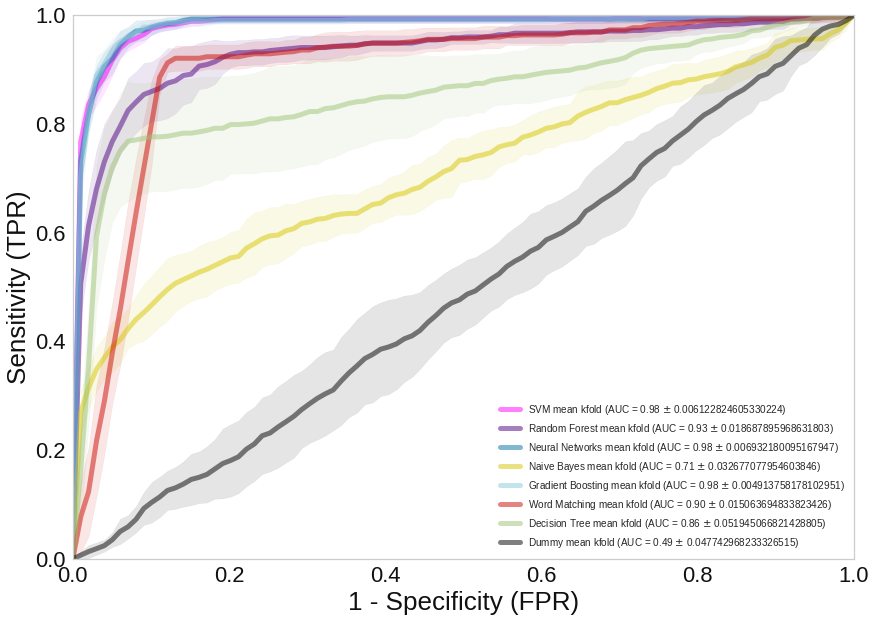

In [109]:
plt = tm.plotROC()
plt.savefig('figures/results/ROC_curve_all_methods.png', bbox_inches='tight')

#### 4.1.1 Student's T-Test relative to Naive Word Matching
Evaluate the difference in performance by applying a t-test

- d_aucs = dictionary with all of the aucs 
- auc_ref = reference auc (in this case the auc of the Word Matching method is used)


In [110]:
d_aucs = tm.getAUC()
auc_ref = d_aucs['Word Matching']
auc_models = d_aucs

for key in d_aucs.keys(): # classifiers with probabilities
    twosample_results = scipy.stats.ttest_ind(d_aucs[key], auc_ref)
    print(key, '\t(p =', str(twosample_results[1]), ')')

SVM 	(p = 1.364013045162427e-11 )
Word Matching 	(p = 1.0 )
Neural Networks 	(p = 2.03723939440859e-11 )
Naive Bayes 	(p = 5.004290148150436e-12 )
Gradient Boosting 	(p = 1.030189883682775e-11 )
Random Forest 	(p = 0.001042972354220433 )
Decision Tree 	(p = 0.022359961358286964 )
Dummy 	(p = 2.5406906392511795e-15 )


### 4.2. AUC - Precision Recall curve

SVM 0.881639138903647 (std : +/-0.021840828567844327 )
Random Forest 0.7128513744071996 (std : +/-0.059714779506722195 )
Neural Networks 0.8683966798986853 (std : +/-0.023067142926399418 )
Naive Bayes 0.37838271377809574 (std : +/-0.041220731930292694 )
Gradient Boosting 0.8645750263048465 (std : +/-0.021235594585409193 )
Word Matching 0.3618198373099902 (std : +/-0.06988321696853234 )
Decision Tree 0.47590040818719553 (std : +/-0.08601329326390648 )
Dummy 0.07626666119184357 (std : +/-0.012656243192795437 )


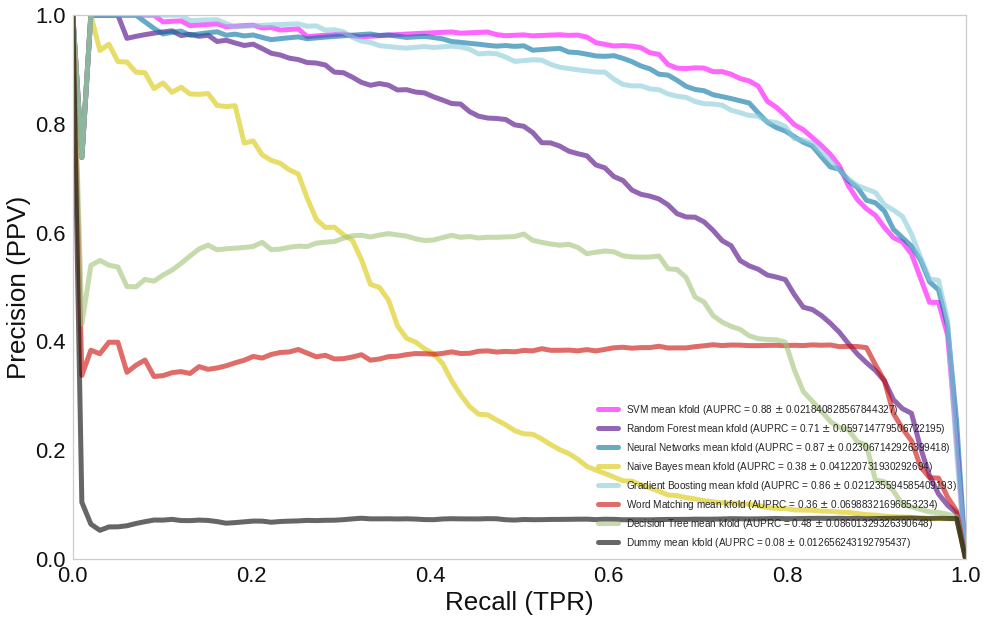

In [111]:
#import matplotlib.pyplot as plt
#import matplotlib.pylab as pylab
plt = tm.plotPrecisionRecall()
plt.savefig('figures/results/PR_curve_all_methods.png', bbox_inches='tight')

#### 4.2.2 Student's T-Test relative to Naive Word Matching (PR-AUC)

In [88]:
d_auprcs = tm.getAUPRC()
auprc_ref = d_auprcs['Word Matching']
auprc_models = d_auprcs

for key in d_auprcs.keys(): # classifiers with probabilities
    twosample_results = scipy.stats.ttest_ind(d_auprcs[key], auprc_ref)
    print(key, '\t(p =', str(twosample_results[1]), ')')

SVM 	(p = 3.2410687978895554e-14 )
Word Matching 	(p = 1.0 )
Neural Networks 	(p = 5.537779041799449e-14 )
Naive Bayes 	(p = 0.5479176473155172 )
Gradient Boosting 	(p = 5.5401414791317974e-14 )
Random Forest 	(p = 1.0603384297156452e-09 )
Decision Tree 	(p = 0.006341445566638645 )
Dummy 	(p = 4.6431300634531214e-10 )


## Step 5: Distribute Model - save classification model
With pickle you can save & load the models

In [89]:
best_model = tm.getTrainedClassifier('Random Forest')
filename='savedModels/RF.sav'
pickle.dump(best_model, open(filename, 'wb'))

### 5.1 Import trained classification model
you can apply this model on a new unlabeled set

In [90]:
filename='savedModels/RF.sav'
loaded_model = pickle.load(open(filename, 'rb'))
probas_ = loaded_model.predict_proba(X)
pred = probas_[:,1]

#### 5.1.2 Example of using a previously constructed model 

FYI : there is currently no dummy data available.. 

In [ ]:
import pickle

model_name='savedModels/RF.sav'
file_name='data/some_file.csv'
text_column='XANTWOORD'

# get EMR text
new_df = pd.read_csv(file_name, sep=';')
X = new_df[text_column].values

# apply built model on provided text
loaded_model = pickle.load(open(model_name, 'rb'))
probas_ = loaded_model.predict_proba(X)
pred = probas_[:,1]


# add predictions to table
new_df['prediction'] = new_df['some_column'].copy()
new_df['prediction'] = pred
new_df[['PATNR', 'RA_case_1y']].to_csv(r'validation/some_file_predictions.csv', sep='|', index=False)

## Step 6: Evaluate best Model
Retrieve the predictions/attributes of the median iteration of the Support Vector Machine

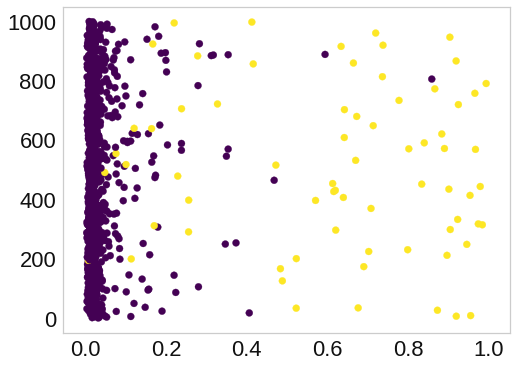

In [98]:
tm.plotScatter('SVM')
plt.savefig('figures/results/scatterplot_SVM.png', bbox_inches='tight')

### 6.2 Visualize optimal cut-off

#### Example: Optimal threshold when Sensitivity of 0.9 is desired
Returns the threshold corresponding with a sensitivity (TPR in code) of 0.9 and the highest possible precision

Generating confusion matrix for SVM based on median Iteration (AUPRC):  4
Other weighing variables:  ['prc']
Thresh: 0.16 
PRC: 	0.66 
Sens: 	0.91 
Spec: 	0.97
Confusion matrix, without normalization
NPV:	0.9933701657458563
ACC:	0.962


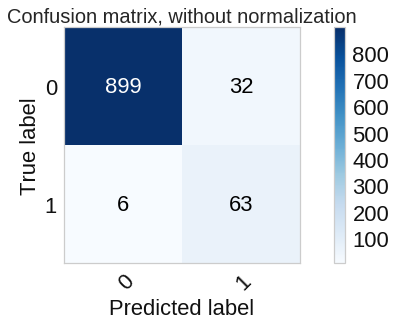

In [112]:
import matplotlib.pylab as pylab
params = {'figure.figsize': (10,5), 'axes.titlesize':20, 'font.weight':'regular', 'xtick.labelsize':22, 'ytick.labelsize':22, 'axes.labelsize':22, 'font.size':22}#fontweight='bold'
pylab.rcParams.update(params)

tm.getConfusionMatrix('SVM', desired=0.9, most_val='tpr')

#### Example: Optimal cut-off when Precision of 0.9 is desired
Returns the threshold corresponding with a precision of 0.9 and the highest possible sensitivity

Generating confusion matrix for SVM based on median Iteration (AUPRC):  4
Other weighing variables:  ['tpr']
Thresh: 0.41 
PRC: 	0.95 
Sens: 	0.77 
Spec: 	1.00
Confusion matrix, without normalization
NPV:	0.9830508474576272
ACC:	0.981


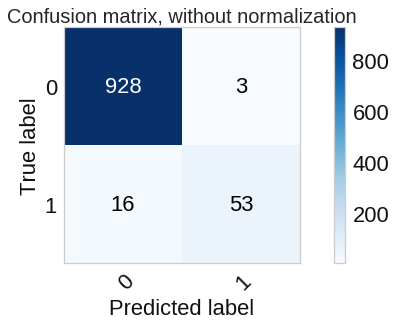

In [114]:
import matplotlib.pylab as pylab
params = {'figure.figsize': (10,5), 'axes.titlesize':20, 'font.weight':'regular', 'xtick.labelsize':22, 'ytick.labelsize':22, 'axes.labelsize':22, 'font.size':22}#fontweight='bold'
pylab.rcParams.update(params)

tm.getConfusionMatrix('SVM', desired=0.9, most_val='prc')

#### Example: Performance at threshold/ cut-off = 0.9

Generating confusion matrix for SVM based on median Iteration (AUPRC):  4
Other weighing variables:  ['tpr', 'prc']
Thresh: 0.99 
PRC: 	1.00 
Sens: 	0.01 
Spec: 	1.00
Confusion matrix, without normalization
NPV:	0.9319319319319319
ACC:	0.932


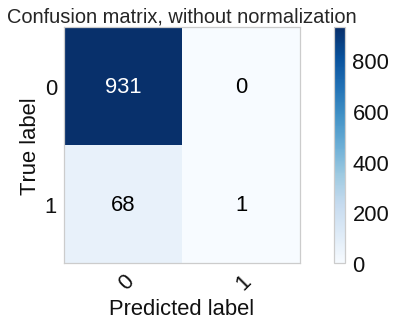

In [113]:
import matplotlib.pylab as pylab
params = {'figure.figsize': (10,5), 'axes.titlesize':20, 'font.weight':'regular', 'xtick.labelsize':22, 'ytick.labelsize':22, 'axes.labelsize':22, 'font.size':22}#fontweight='bold'
pylab.rcParams.update(params)

tm.getConfusionMatrix('SVM', desired=0.99, most_val='threshold')

## Extra: (Step 7) Visualize most important features 
Optional Visualizations 

Keep in mind: feature importance is not currently working -> so the examples below are general visualizations
### 7.1 Chi-squared test of top 20 features

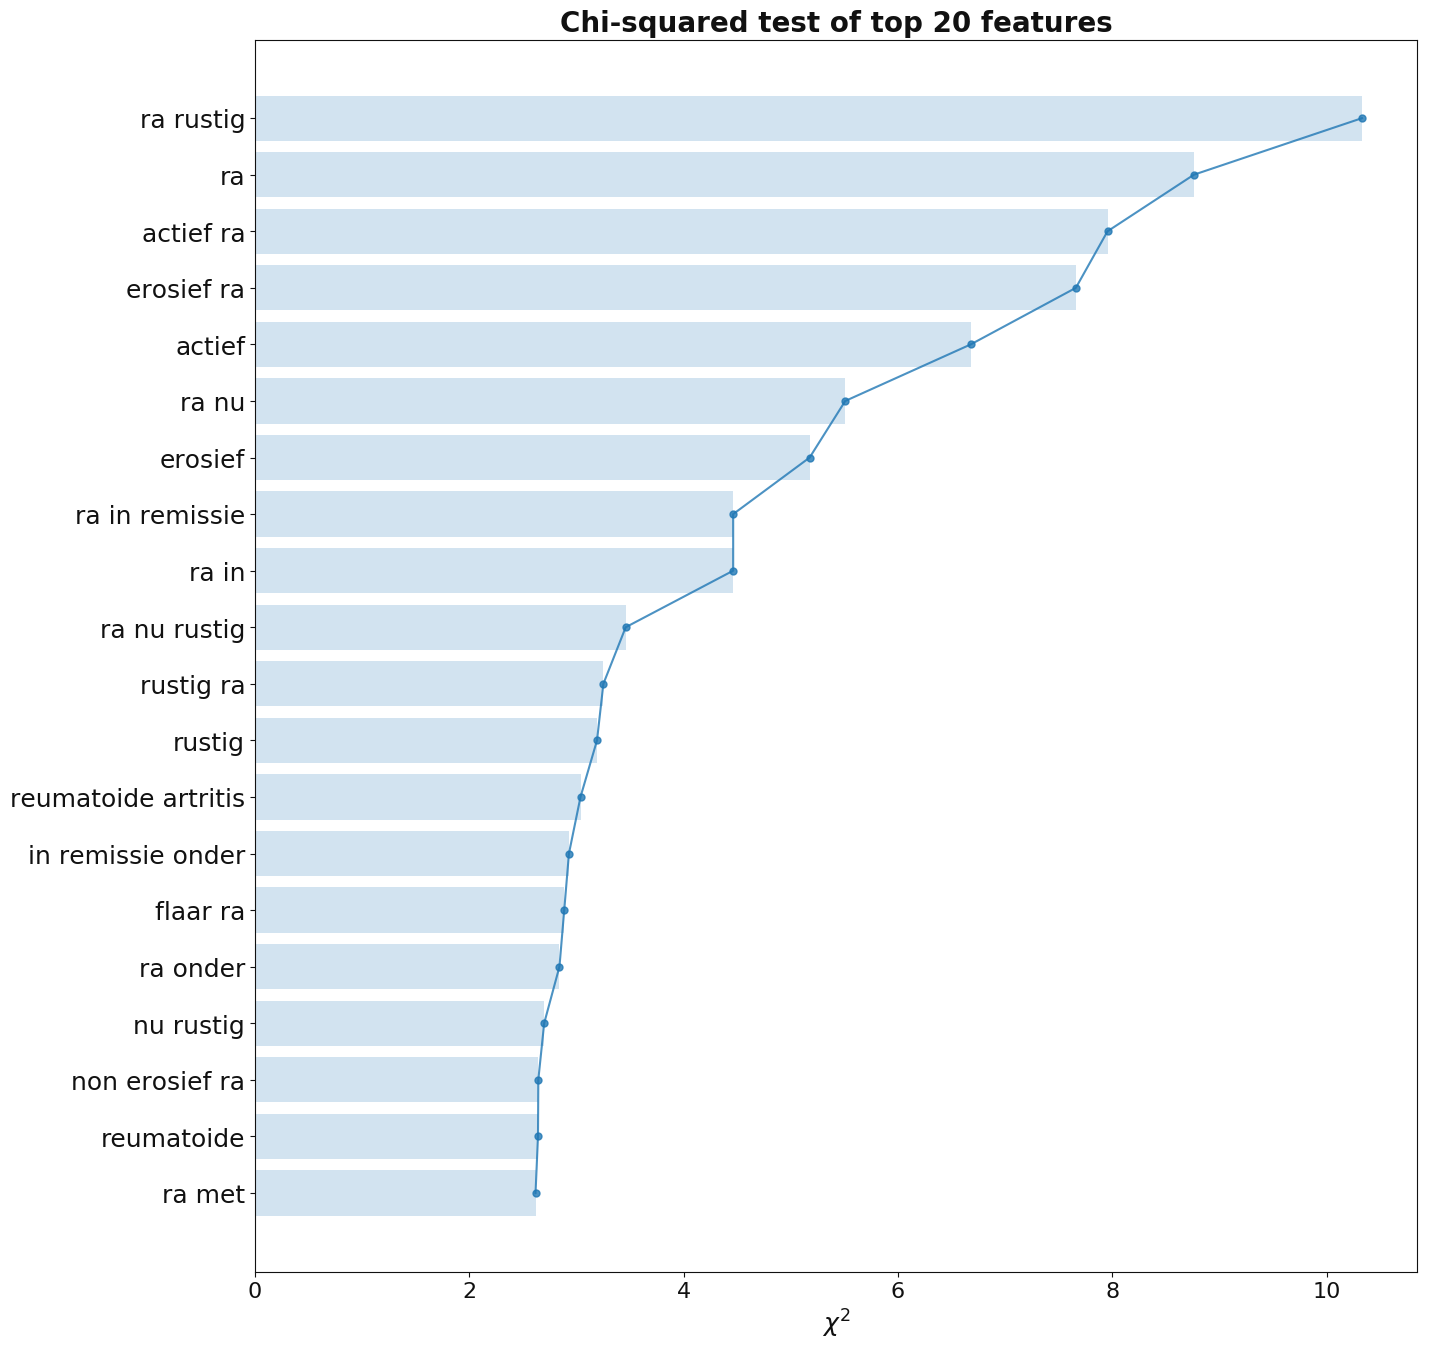

In [64]:
import importlib
importlib.reload(bc)
plt = bc.plotFeatureChiSquared(X[train_index], np.array(y)[train_index], nr_features=20, ngram_range=(1,3))

plt.show()

### 7.2 Pearson correlation per feature

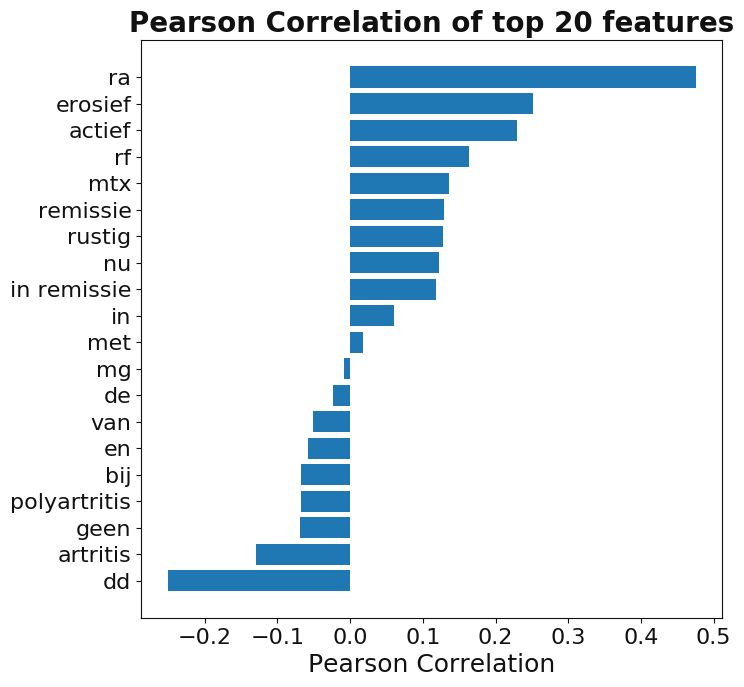

In [65]:
plt = bc.plotFeatureCorrelation(X[train_index], np.array(y_b)[train_index], nr_features=20, ngram_range=(1,3))
locs, labels = plt.yticks()  

#plt.yticks(locs, ['ra', 'erosive', 'active', 'not-active', 'on', 'rf',  'currently', 'not', 'remission', 'in', 'the', 'with', 'and', 'no', 'arthrosis', 'in case of/by', 'polyarthritis', 'of/from', 'arthritis', 'dd'][::-1])
plt.show()

### 7.3 Explained variance per feature according to the best performing model
Feature importance is calculated with the leave-one-out method to assess the explained variance of said feature. In other words: The importance of each feature reflects the model error caused by exclusion of said feature.

- The feature importance can only be calculated for decision tree like classifiers

25191 680
[0.00796001 0.0097106  0.00983234 0.01175178 0.01191231 0.01193894
 0.01334354 0.01568426 0.01685358 0.01751165 0.01776812 0.02097782
 0.0240077  0.02440107 0.03188207 0.03451241 0.04310101 0.08744242
 0.2779161  0.31149228]


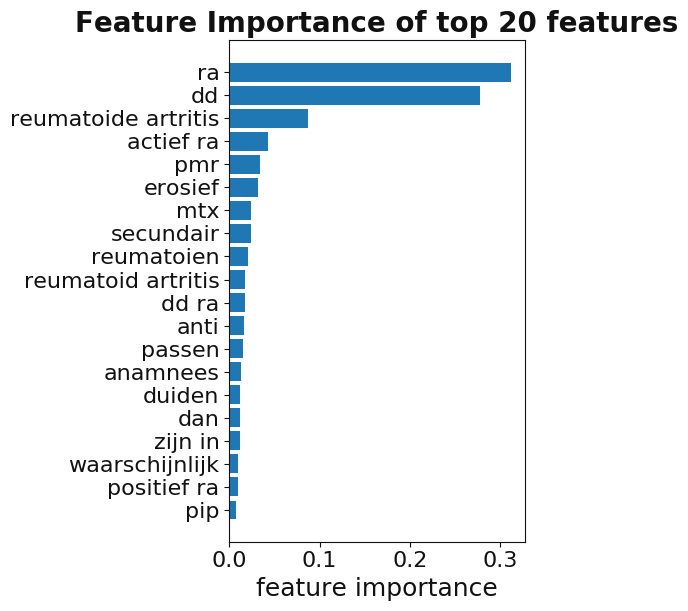

In [67]:
import importlib
importlib.reload(bc)

params = {'axes.titlesize':15, 'figure.figsize': (10,7)}
pylab.rcParams.update(params)
plt = bc.plotFeatureImportance(tuple(classifier)[1], X[train_index], np.array(y_b)[train_index], nr_features=20, top=True, ngram_range=(1,3))
#plt.yticks(locs, ['ra', 'mtx', 'erosive', 'rheumatoid arthritis', 'rheumatoid', 'erosive ra', 'in',  'seropositive', 'rf', 'positive', 'ccp', 'the', 'positive erosion', 'active', 'acpa', 'ra in', 'mg', 'ra in remission', 'polyarthritis', 'of/from', 'arthritis', 'dd'][::-1])
locs, labels = plt.yticks()

plt.show()

### 7.4 Trainingset | Lexical Dispersion Plot 

/home/tdmaarseveen/.conda/envs/ml_env/lib/python3.5/site-packages/ipykernel_launcher.py:1: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  """Entry point for launching an IPython kernel.


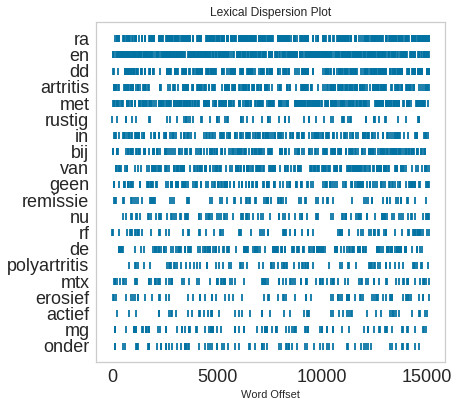

In [89]:
bc.plotLexicalDispersion(X[train_index], ngram_range = (1,1))

### 7.5 Testset | Lexical Dispersion Plot 

/home/tdmaarseveen/.conda/envs/ml_env/lib/python3.5/site-packages/ipykernel_launcher.py:1: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  """Entry point for launching an IPython kernel.


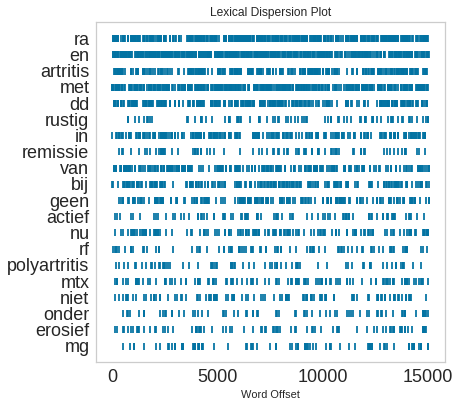

In [90]:
bc.plotLexicalDispersion(X[test_index], ngram_range = (1,1))

### 7.6 Plot distribution of n=50 prevalent features
Should be comparable -> otherwise you dont have a representable train/test set

##### Input:
- nr_features = number of features to draw in the distribution plot

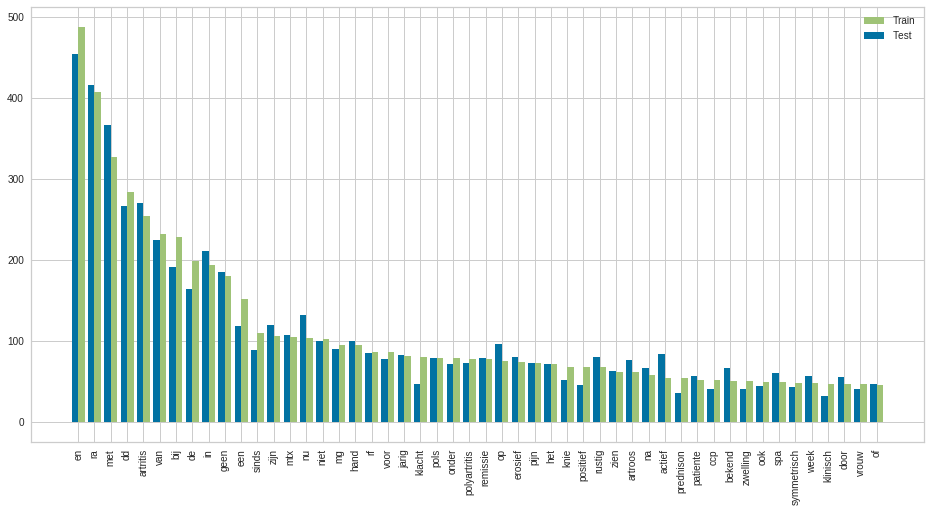

In [91]:
import matplotlib.pyplot as plt

# Assess most prevalent features
bc.plotTrainTestDistribution(X[train_index], X[test_index], nr_features=50) 

### 7.7 Graphviz | Write GBM structure to 
Outputs a file that can be visualized in http://viz-js.com/ 
##### Input:
- sub_tree = specify the subtree to draw (0-99 in this case)

In [ ]:
sub_tree = 99

test_clf = tuple(classifier)[1] # get classifier
tree2 = test_clf.estimators_[sub_tree, 0] 
lbls = tuple(estimator.steps[0])[1].get_feature_names()
bc.exportTreeGraphViz(X[train_index], tree2, lbls, 'GBM_structure_subtree' + str(sub_tree))